In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [30]:
df = pd.read_excel("Harga Bahan Pokok per Bulan.xlsx", index_col=0)
df = df.T  # Transpose: bulan jadi index


In [31]:
# Ubah nama bulan ke format Inggris
bulan_mapping = {
    'JANUARI': 'January', 'FEBRUARI': 'February', 'MARET': 'March',
    'APRIL': 'April', 'MEI': 'May', 'JUNI': 'June', 'JULI': 'July',
    'AGUSTUS': 'August', 'SEPTEMBER': 'September', 'OKTOBER': 'October',
    'NOVEMBER': 'November', 'DESEMBER': 'December'
}
df.index = df.index.str.strip()
for indo, eng in bulan_mapping.items():
    df.index = df.index.str.replace(indo, eng, regex=False)

df.index = pd.to_datetime(df.index, format='%Y %B')
df = df.sort_index()
df = df.astype(float).interpolate().fillna(method='bfill').fillna(method='ffill')


/var/folders/t5/klbl44s56vjcx1ctvfn4c91c0000gn/T/ipykernel_19049/4191411065.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.astype(float).interpolate().fillna(method='bfill').fillna(method='ffill')


In [32]:
# === Fungsi sequence ===
def create_sequences(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:i+n_input])
        y.append(data[i+n_input])
    return np.array(X), np.array(y)


In [38]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

n_input = 12
n_forecast = 6
hasil_prediksi = {}

for kolom in df.columns:
    data_asli = df[kolom].values.reshape(-1, 1)

    # Scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_asli)

    # Buat sequence
    X, y = [], []
    for i in range(len(scaled_data) - n_input):
        X.append(scaled_data[i:i+n_input])
        y.append(scaled_data[i+n_input])
    X, y = np.array(X), np.array(y)

    # Bangun model
    model = Sequential()
    model.add(Input(shape=(n_input, 1)))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training
    model.fit(X, y, epochs=100, verbose=0)

    # Prediksi 6 bulan ke depan
    input_pred = scaled_data[-n_input:]
    forecast_scaled = []

    for _ in range(n_forecast):
        pred = model.predict(input_pred.reshape(1, n_input, 1), verbose=0)
        forecast_scaled.append(pred[0, 0])
        input_pred = np.append(input_pred[1:], pred).reshape(n_input, 1)

    # Kembalikan ke skala asli
    forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
    forecast = np.round(forecast)  # Bulatkan ke angka bulat
    hasil_prediksi[kolom] = forecast



In [39]:
# Buat tanggal prediksi
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='MS')

# Gabungkan ke DataFrame
df_hasil = pd.DataFrame(hasil_prediksi, index=future_dates)
df_hasil

,Beras,Gula Pasir Kemasan,Minyak goreng kemasan,Garam Halus,Daging Sapi Paha,Daging Ayam Ras,Telor Ayam Ras,Tahu Putih,Tempe Bungkus,Cabai Merah Besar,Cabai Merah Keriting,Cabai Rawit Merah,Cabai Rawit Hijau,Bawang Putih,Bawang Merah,Ikan Bandeng,Kentang Sedang
2025-05-01,74012.0,19698.0,19871.0,12789.0,143512.0,41424.0,34021.0,14009.0,19110.0,60094.0,58871.0,75379.0,56591.0,47621.0,45220.0,39126.0,22396.0
2025-06-01,75484.0,19944.0,20734.0,12910.0,146242.0,42854.0,34756.0,14044.0,19110.0,60033.0,59055.0,77680.0,57340.0,47921.0,44940.0,39516.0,22458.0
2025-07-01,77228.0,20230.0,21730.0,12943.0,149235.0,44506.0,35564.0,14028.0,19089.0,60670.0,59599.0,79859.0,57893.0,48210.0,45014.0,39711.0,22413.0
2025-08-01,79386.0,20851.0,22608.0,12981.0,153296.0,45739.0,36159.0,14016.0,19073.0,61468.0,60377.0,81674.0,58282.0,48662.0,45641.0,39953.0,22340.0
2025-09-01,82026.0,21742.0,23577.0,13023.0,158423.0,47064.0,36887.0,14008.0,19060.0,62458.0,61462.0,83436.0,58680.0,49227.0,46698.0,40219.0,22275.0
2025-10-01,84660.0,22878.0,24529.0,13078.0,164953.0,49090.0,38313.0,14000.0,19047.0,63798.0,63271.0,86225.0,59283.0,49932.0,47911.0,40510.0,22228.0


In [40]:
# Buat DataFrame hasil prediksi
df_hasil = pd.DataFrame(hasil_prediksi, index=future_dates)

# Ubah tipe data ke integer
df_hasil = df_hasil.round(0).astype("int64")

# Tampilkan hasil
df_hasil


,Beras,Gula Pasir Kemasan,Minyak goreng kemasan,Garam Halus,Daging Sapi Paha,Daging Ayam Ras,Telor Ayam Ras,Tahu Putih,Tempe Bungkus,Cabai Merah Besar,Cabai Merah Keriting,Cabai Rawit Merah,Cabai Rawit Hijau,Bawang Putih,Bawang Merah,Ikan Bandeng,Kentang Sedang
2025-05-01,74012,19698,19871,12789,143512,41424,34021,14009,19110,60094,58871,75379,56591,47621,45220,39126,22396
2025-06-01,75484,19944,20734,12910,146242,42854,34756,14044,19110,60033,59055,77680,57340,47921,44940,39516,22458
2025-07-01,77228,20230,21730,12943,149235,44506,35564,14028,19089,60670,59599,79859,57893,48210,45014,39711,22413
2025-08-01,79386,20851,22608,12981,153296,45739,36159,14016,19073,61468,60377,81674,58282,48662,45641,39953,22340
2025-09-01,82026,21742,23577,13023,158423,47064,36887,14008,19060,62458,61462,83436,58680,49227,46698,40219,22275
2025-10-01,84660,22878,24529,13078,164953,49090,38313,14000,19047,63798,63271,86225,59283,49932,47911,40510,22228


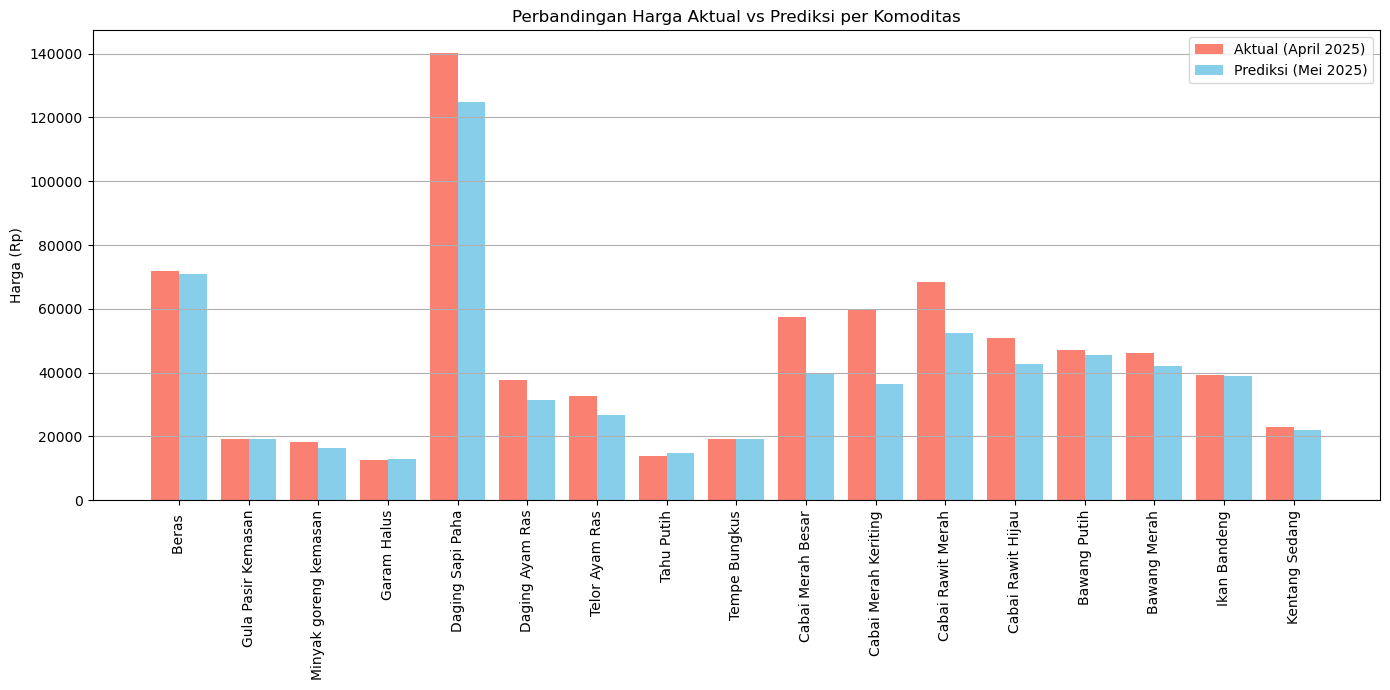

In [49]:
# Ambil data aktual terakhir
actual_last = df.iloc[-1]

# Ambil data prediksi (pastikan sudah dibulatkan)
predicted_next = predicted_df.iloc[0]

# Plot perbandingan
plt.figure(figsize=(14, 7))
x = np.arange(len(df.columns))

plt.bar(x - 0.2, actual_last.values, width=0.4, label='Aktual (April 2025)', color='salmon')
plt.bar(x + 0.2, predicted_next.values, width=0.4, label='Prediksi (Mei 2025)', color='skyblue')

plt.xticks(x, df.columns, rotation=90)
plt.ylabel("Harga (Rp)")
plt.title("Perbandingan Harga Aktual vs Prediksi per Komoditas")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [58]:
# Hitung evaluasi dalam skala normalisasi
actual_scaled = scaler.transform([df.iloc[-1].values])[0]
predicted_scaled = scaler.transform([predicted_df.iloc[0].values])[0]

mae_scaled = mean_absolute_error(actual_scaled, predicted_scaled)
mse_scaled = mean_squared_error(actual_scaled, predicted_scaled)
rmse_scaled = np.sqrt(mse_scaled)

print("📉 Evaluasi Model:")
print(f"MSE : {mse_scaled:.6f}")
print(f"MAE : {mae_scaled:.6f}")
print(f"RMSE: {rmse_scaled:.6f}")


📉 Evaluasi Model:
MSE : 0.181772
MAE : 0.335987
RMSE: 0.426348
